In [1]:
#=============================================================================
##############################################################################
##############################################################################
# IMPORT ALL TIME PACKAGES
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle, time, random, sys, warnings
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves
##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

print('***********************************************************************')
print('***********************************************************************')
print('***********************************************************************')
print('********************** STARTING LSTM BALANCED *************************')
print('***********************************************************************')
print('***********************************************************************')
print('***********************************************************************')
##############################################################################
# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================


2023-08-01 21:50:15.666579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2023-08-01 21:50:15.666608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


***********************************************************************
***********************************************************************
***********************************************************************
********************** STARTING LSTM BALANCED *************************
***********************************************************************
***********************************************************************
***********************************************************************


In [2]:
t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
#df_patients_16_18, df_admissions_16_18, df_eobs_16_18 = load_fn.Load_data()
#df_patients_19_20, df_admissions_19_20, df_eobs_19_20 = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18.pickle','rb')).drop(columns = 'no_sample_series')
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb')).drop(columns = 'no_sample_series')


# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# List of features ------------------------
feat_list = X_data_16_18.columns.tolist()
feat_list = feat_list[1:-1]

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)
# ============================================================================

Elapsed time loading data: 39.617722511291504


In [3]:
feature   = 'heart_rate'

df        = X_data_16_18[feature]
lst_admns = X_data_16_18['admission_id'].unique().tolist()
mort_df   = X_data_16_18[['admission_id', 'Mortality']].groupby(by = ['admission_id']).mean()
mort_dict = dict(zip(mort_df.index, mort_df['Mortality']))
lst_mort  = [mort_dict[i] for i in lst_admns]

x = np.array(df).reshape((len(lst_admns), int(len(df) / len(lst_admns))))
x.shape

(9390, 144)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x)
# Apply transform to both the training set and the test set.
x = scaler.transform(x)
#test_img = scaler.transform(test_img)

# 2 componennts

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents[:,:2]
             , columns = ['principal component 1', 'principal component 2'])

principalDf['target'] = lst_mort

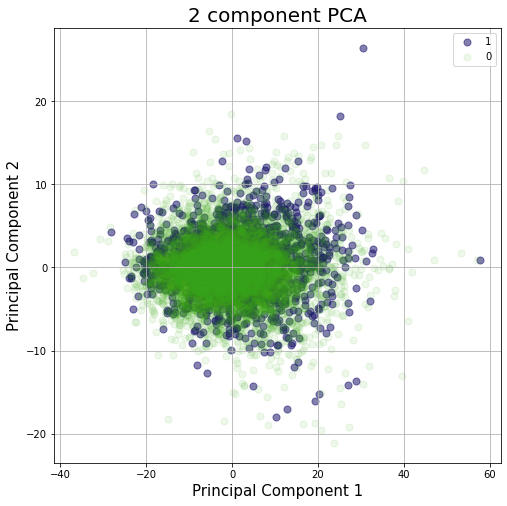

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
#colors = ['r', 'b']
colors = ['#1A156b8a', '#40ac1917']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# 3d compnents


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf['target'] = lst_mort

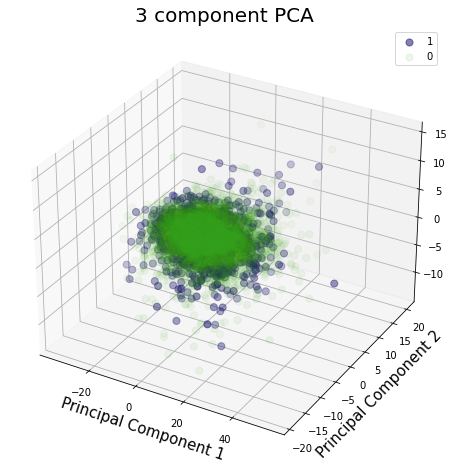

In [8]:
fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
ax = plt.axes(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [1,0]
#colors = ['r', 'b']
colors = ['#1A156b8a', '#40ac1917']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    xdata = principalDf.loc[indicesToKeep, 'principal component 1']
    ydata = principalDf.loc[indicesToKeep, 'principal component 2']
    zdata = principalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter3D(xdata, ydata, zdata, c = color, s = 50);
    
ax.legend(targets)
ax.grid()

In [9]:
import plotly.express as px
cols  = ['xdata','ydata','zdata','color']
df_plot = pd.DataFrame(columns = cols)
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    xdata = principalDf.loc[indicesToKeep, 'principal component 1']
    ydata = principalDf.loc[indicesToKeep, 'principal component 2']
    zdata = principalDf.loc[indicesToKeep, 'principal component 3']
    
    df_temp = pd.DataFrame(dict(zip(cols, [xdata, ydata, zdata, [color] * len(xdata)])))
    df_plot =  pd.concat([df_plot, df_temp])
    
    
display(df_plot.head(3))
px.scatter_3d(df_plot,x='xdata', y='ydata', z='zdata',  color='color')

xdata     ydata     zdata      color
7    8.684963 -4.031431  0.198867  #1A156b8a
20   8.641475  -1.26191 -0.768431  #1A156b8a
28 -12.498694 -3.428089  -1.35081  #1A156b8a

In [10]:
#https://towardsdatascience.com/how-to-create-dynamic-3d-scatter-plots-with-plotly-6371adafd14

# Differencing the timeseries

In [11]:
feature   = 'heart_rate'

df        = X_data_16_18[feature]
lst_admns = X_data_16_18['admission_id'].unique().tolist()
mort_df   = X_data_16_18[['admission_id', 'Mortality']].groupby(by = ['admission_id']).mean()
mort_dict = dict(zip(mort_df.index, mort_df['Mortality']))
lst_mort  = [mort_dict[i] for i in lst_admns]

x = np.array(df).reshape((len(lst_admns), int(len(df) / len(lst_admns))))
x.shape

(7657, 144)

In [12]:
x_diff = x.copy()
for i in range(x.shape[1] - 1):
    x_diff[:, i+1] = x[:, i+1] - x[:, i]
x_diff = x_diff[:, 1:]
x_diff.shape    

(7657, 143)

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x= scaler.fit_transform(x_diff)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_diff)
# Apply transform to both the training set and the test set.
x = scaler.transform(x_diff)
#test_img = scaler.transform(test_img)

# 2 Components

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['target'] = lst_mort

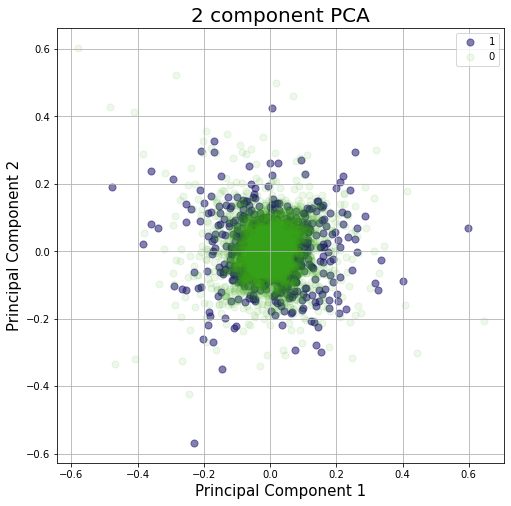

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
#colors = ['r', 'b']
colors = ['#1A156b8a', '#40ac1917']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# 3 Components

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf['target'] = lst_mort

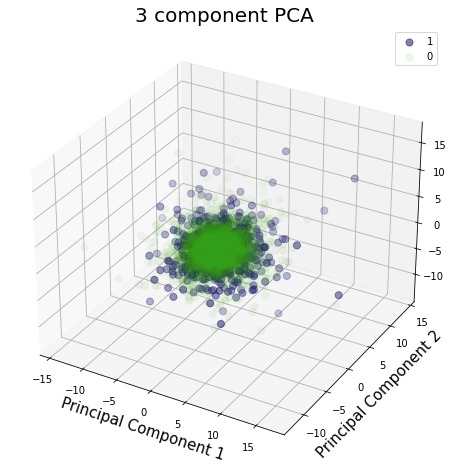

In [17]:
fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
ax = plt.axes(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [1,0]
#colors = ['r', 'b']
colors = ['#1A156b8a', '#40ac1917']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    xdata = principalDf.loc[indicesToKeep, 'principal component 1']
    ydata = principalDf.loc[indicesToKeep, 'principal component 2']
    zdata = principalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter3D(xdata, ydata, zdata, c = color, s = 50);
    
ax.legend(targets)
ax.grid()

In [18]:
import plotly.express as px
cols  = ['xdata','ydata','zdata','color']
df_plot = pd.DataFrame(columns = cols)
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    xdata = principalDf.loc[indicesToKeep, 'principal component 1']
    ydata = principalDf.loc[indicesToKeep, 'principal component 2']
    zdata = principalDf.loc[indicesToKeep, 'principal component 3']
    
    df_temp = pd.DataFrame(dict(zip(cols, [xdata, ydata, zdata, [color] * len(xdata)])))
    df_plot =  pd.concat([df_plot, df_temp])
    
display(df_plot.head(3))
px.scatter_3d(df_plot,x='xdata', y='ydata', z='zdata',  color='color')

xdata     ydata     zdata      color
7   0.957712  0.063057 -2.599265  #1A156b8a
20  2.467821 -1.177596  0.480591  #1A156b8a
28 -2.762964 -3.624799  1.502076  #1A156b8a

# Greater decomposition

In [19]:
feature   = 'heart_rate'

df        = X_data_16_18[feature]
lst_admns = X_data_16_18['admission_id'].unique().tolist()
mort_df   = X_data_16_18[['admission_id', 'Mortality']].groupby(by = ['admission_id']).mean()
mort_dict = dict(zip(mort_df.index, mort_df['Mortality']))
lst_mort  = [mort_dict[i] for i in lst_admns]

x = np.array(df).reshape((len(lst_admns), int(len(df) / len(lst_admns))))

In [20]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x)
# Apply transform to both the training set and the test set.
x = scaler.transform(x)
#test_img = scaler.transform(test_img)

In [21]:
from sklearn.preprocessing import StandardScaler

x_diff = x.copy()
for i in range(x.shape[1] - 1):
    x_diff[:, i+1] = x[:, i+1] - x[:, i]
x_diff = x_diff[:, 1:]
x_diff.shape    


scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_diff)
# Apply transform to both the training set and the test set.
x = scaler.transform(x_diff)
#test_img = scaler.transform(test_img)

In [22]:
from sklearn.decomposition import PCA
k = 10
pca = PCA(n_components=k)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component ' + str(i+1) for i in range(k)])

principalDf['target'] = lst_mort

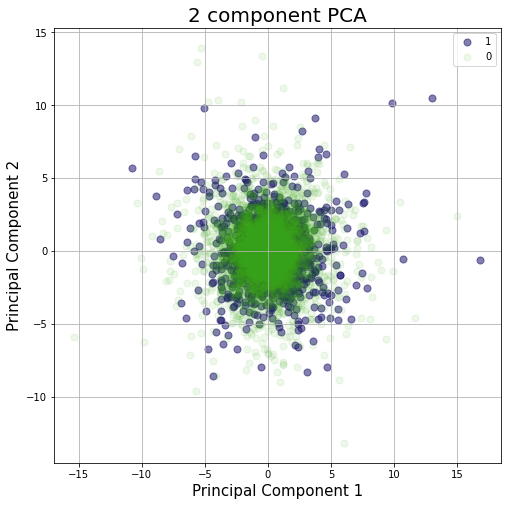

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
#colors = ['r', 'b']
colors = ['#1A156b8a', '#40ac1917']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color, s = 50)
ax.legend(targets)
ax.grid()

In [29]:
import plotly.express as px
cols  = ['xdata','ydata','zdata','color']
df_plot = pd.DataFrame(columns = cols)
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    xdata = principalDf.loc[indicesToKeep, 'principal component 1']
    ydata = principalDf.loc[indicesToKeep, 'principal component 2']
    zdata = principalDf.loc[indicesToKeep, 'principal component 3']
    
    df_temp = pd.DataFrame(dict(zip(cols, [xdata, ydata, zdata, [color] * len(xdata)])))
    df_plot =  pd.concat([df_plot, df_temp])
    
display(df_plot.head(3))
px.scatter_3d(df_plot,x='xdata', y='ydata', z='zdata',  color='color')

xdata     ydata     zdata      color
7    0.97021  0.072438 -2.412808  #1A156b8a
20  2.121975 -1.475002  0.220963  #1A156b8a
28 -3.217688 -3.142392  0.489618  #1A156b8a

# Selecting PCA decomposition

In [49]:
feature   = 'heart_rate'

df        = X_data_16_18[feature]
lst_admns = X_data_16_18['admission_id'].unique().tolist()
mort_df   = X_data_16_18[['admission_id', 'Mortality']].groupby(by = ['admission_id']).mean()
mort_dict = dict(zip(mort_df.index, mort_df['Mortality']))
lst_mort  = [mort_dict[i] for i in lst_admns]

x = np.array(df).reshape((len(lst_admns), int(len(df) / len(lst_admns))))
x.shape

(7657, 144)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x= scaler.fit_transform(x)

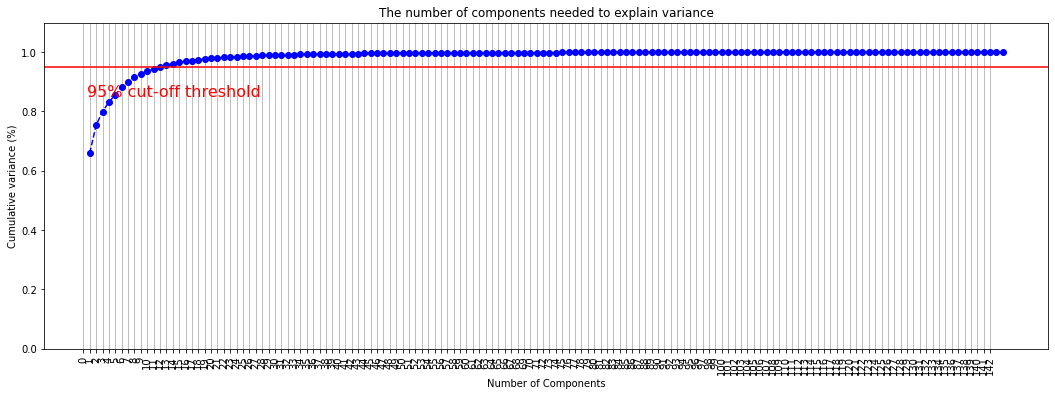

In [55]:
pca = PCA().fit(x)

plt.rcParams["figure.figsize"] = (18,6)

fig, ax = plt.subplots()
xi = np.arange(1, x.shape[1] + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 143, step=1),rotation = 90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [24]:
dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature\r':[30, 45],'sbp': [60,200], 'dbp':[40,120],
                 'Oxygen_Saturation':[60,100], 'ews':[0,21]}

dict_sypmt_range = {'rr':[12, 25], 'heart_rate':[60,100], 'temperature':[36, 38],'sbp': [90,120], 'dbp':[60,80],
                 'Oxygen_Saturation':[85,100], 'ews':[0,21], 'UREA':[6, 24]}

############################## DECEASED ######################################


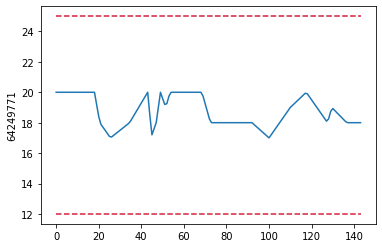

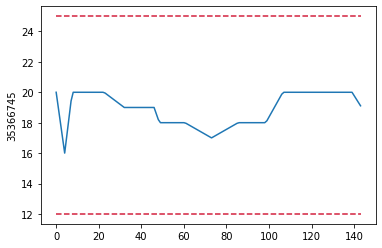

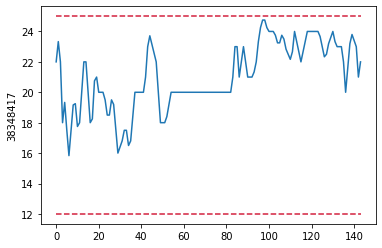

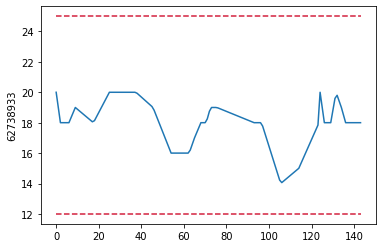

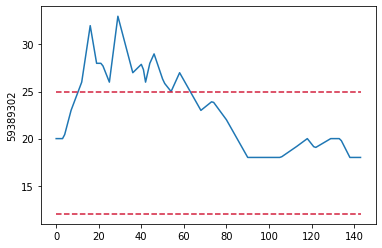

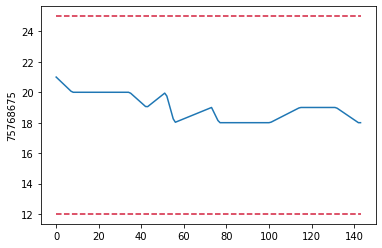

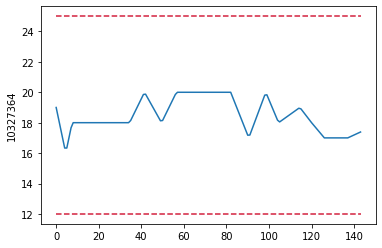

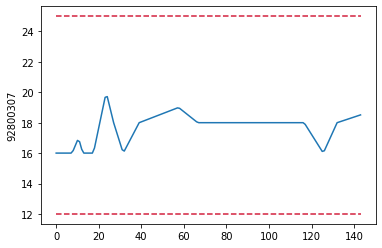

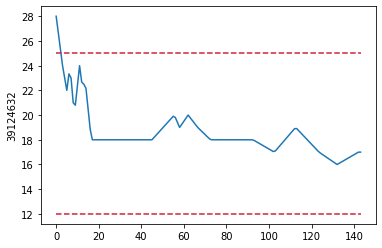

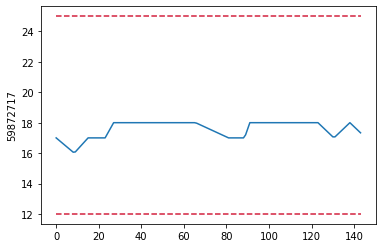

############################## DISCHARGED ######################################


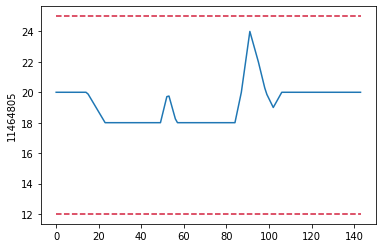

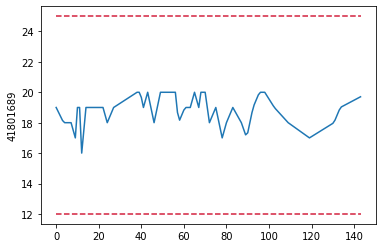

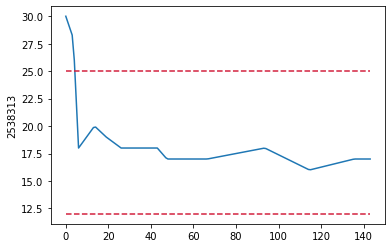

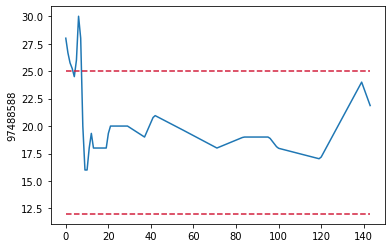

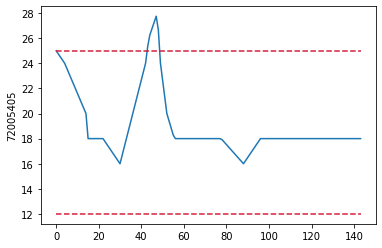

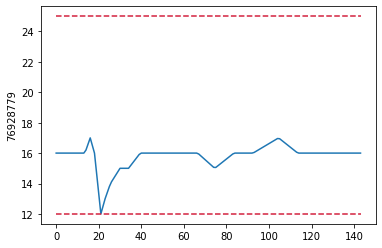

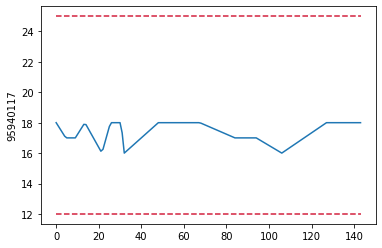

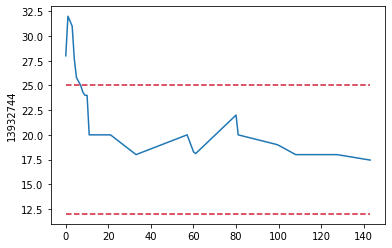

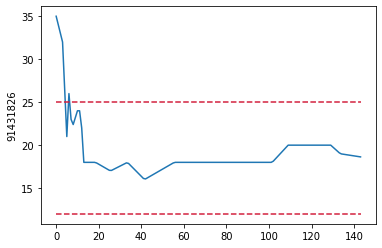

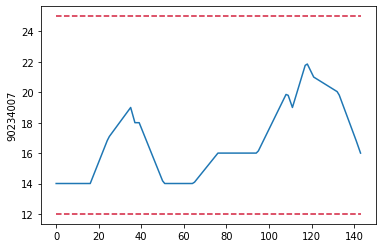

In [25]:
import random
random.seed(10)
#lenght_ts = 144
feature   = 'rr'

print('############################## DECEASED ######################################')
df = X_data_16_18[['admission_id', feature, 'Mortality']]
df = df[df['Mortality'] == 1]
lst_adms = df['admission_id'].unique().tolist()
lst_adms_plot  = random.choices(lst_adms, k = 10)

for adm in lst_adms_plot:
    y = df[df['admission_id'] == adm][feature]
    x = range(len(y))
    plt.plot(x,y)
    plt.plot(x, [dict_sypmt_range[feature][0]] * len(y), linestyle='dashed', color = '#D21F3C')
    plt.plot(x, [dict_sypmt_range[feature][1]] * len(y), linestyle='dashed', color = '#D21F3C')
    plt.ylabel(adm)
    plt.show()#break
    
print('############################## DISCHARGED ######################################')
df = X_data_16_18[['admission_id', feature, 'Mortality']]
df = df[df['Mortality'] == 0]
lst_adms = df['admission_id'].unique().tolist()
lst_adms_plot  = random.choices(lst_adms, k = 10)

for adm in lst_adms_plot:
    y = df[df['admission_id'] == adm][feature]
    x = range(len(y))
    plt.plot(x,y)
    plt.plot(x, [dict_sypmt_range[feature][0]] * len(y), linestyle='dashed', color = '#D21F3C')
    plt.plot(x, [dict_sypmt_range[feature][1]] * len(y), linestyle='dashed', color = '#D21F3C')
    plt.ylabel(adm)
    plt.show()#break

In [26]:
dict_sypmt_range[feature][0]


12

In [27]:
adm

90234007

In [28]:
df[df['admission_id'] == adm]

admission_id         rr  Mortality
509616     90234007  14.000000        0.0
509617     90234007  14.000000        0.0
509618     90234007  14.000000        0.0
509619     90234007  14.000000        0.0
509620     90234007  14.000000        0.0
...             ...        ...        ...
509755     90234007  17.562500        0.0
509756     90234007  17.187500        0.0
509757     90234007  16.799999        0.0
509758     90234007  16.400000        0.0
509759     90234007  16.000000        0.0

[144 rows x 3 columns]